# IGL x INGENIO, July 2023: Dictionary methods

Today's notebook presents basic dictionary-based methods as it recreates the baseline method followed by Hassan and coauthors in their 2019 QJE academic paper, [_Firm-Level Political Risk: Measurements and Effects_](https://www.bu.edu/econ/files/2019/05/Firm-levelPoliticalRisk.pdf). 

The paper uses political and non-political dictionaries (as well as sentiment dictionaries à la [Loughran and McDonald](https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1540-6261.2010.01625.x)) to study the effects political events have on firm-level uncertainty by observing companies' quarterly earnings conference calls and drawing measures of event coverage and uncertainty assesment. More specifically, in their baseline scenario the authors build a dictionary of political terms not included in non-political jargon (so as to clearly distinguish from terms that may be common to both) and track occurrences of such terms when in close proximity of words that relate to risk.

The premise, albeit simple, proves robust to many specifications and performs admirably in capturing political risk. The measure varies across sectors and over time in a logical manner,  with spikes around federal elections and other typically turbulent political events. Increases in the firm-level emasure of risk are also associated with increases in stock return volatility and donations to political campaigns,  as well as with decreases in firms' investment, planned capital expenditures, and hiring. Contrary to traditional assumptions, the authors show that most of the variation in measured political risk occurs at the firm level, rather than the sector one. 

$$
y_{i t}=\delta_{t}+\delta_{s}+\beta P R i s k_{i t}+\gamma X_{i t}+\epsilon_{i t}
$$

<div style="text-align:center"><img src="figs/C2_1.png" width="800" align="center"></div>

<div style="text-align:center"><img src="figs/C2_2.png" width="600" align="center"></div>
In the code that follows, we will adopt a slightly different approach, partly because we do not have a corpus of conference call transcripts. Instead, we will present you the tools necessary to replicate part of the paper on a different body of text, namely close to 2 million news articles published between 2016 and 2020 by a handful of news sources. As a mock exercise, we will look at measures of non-economic political risk in China and India over the four years, by building such a dictionary in the spirit of Hassan and coauthors. We will also present a basic 8-sentiment lexicon to use in combination with the dictionary, and will review some of the code already presented yesterday.

In [1]:
# Basic libraries
import pandas as pd
pd.set_option('max_colwidth', 200)

import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

## Load data 

Let's load some newspapers data to use as training corpus, as well as a Lexicon dictionary (forget about this for now) and the synonyms of risk.

In [ ]:
from igl_data.data.applications.hassan19 import get_hassan_data
main_df, emotions_df, risk_syn = get_hassan_data()

In [7]:
# Return the row-length and column-length in your dataframe "main_df"
main_df.shape

(63330, 6)

In [8]:
# Return handful of first rows in your dataframe "main_df"
main_df.sample()

,date,author,title,article,section,publication
58758,2018-12-09,"By Yong Xiong and Susannah Cullinane, CNN","China summons US, Canadian ambassadors in 'strong protest ' over Huawei CFO's arrest","Beijing (CNN)The Chinese Foreign Ministry is summoning the US and Canadian ambassadors in protest over the detention of a Huawei executive in Vancouver, describing it as ""lawless"" and ""extremely v...",tech,CNN


In [58]:
# Print the list of unique publication strings in your dataframe "main_df"
print(main_df.publication.unique())

['Reuters' 'Business Insider' 'TechCrunch' 'Axios' 'Economist' 'Mashable'
 'CNN' 'CNBC' 'The Hill' 'The New York Times']


In [59]:
# Print the first article (python lists are 0-indexed)
main_df.article[0]

'WASHINGTON (Reuters) - China has delivered a written response to U.S. demands for wide-ranging trade reforms, three U.S. government sources said on Wednesday, a move that could trigger more formal negotiations to resolve a withering trade war between the world’s top economies.  U.S. President Donald Trump has imposed tariffs on $250 billion of Chinese imports to force concessions from Beijing on the list of demands that would change the terms of trade between the two countries. China has responded with import tariffs on U.S. goods.   Trump is expected to meet Chinese President Xi Jinping on the sidelines of a G20 summit in Argentina at the end of November and in early December.   The U.S. president has repeatedly railed against Beijing over intellectual property theft, industrial subsidies, Chinese entry barriers to American businesses and the U.S. trade deficit with China.  Three U.S. government sources told Reuters on Wednesday that China had sent a response to U.S. demands on those

In [60]:
for col in main_df.columns:                                        # for each column in your "main_df" dataframe
    miss_tp = main_df[col].isna().sum()                            # select the pandas series corresponding to the column, call function isna(), sum count across column
    print(f'Number of missing observations in {col}: {miss_tp}')   # Print results using f-strings

Number of missing observations in date: 0
Number of missing observations in author: 294108
Number of missing observations in title: 0
Number of missing observations in article: 8135
Number of missing observations in section: 164050
Number of missing observations in publication: 0


#### Basic plots

In [61]:
# Libraries for plotting results
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from wordcloud import WordCloud

In [62]:
# Select the "section" pandas series, pass function value_counts(), take first 50 results, take their names, pass them as list
top50_sects = main_df['section'].value_counts()[:50].index.tolist()

In [63]:
# Access a group of rows using loc passing a boolean whether each row's section is in the top 50 chosen above 
plt_df = main_df.loc[main_df.section.isin(top50_sects)]

In [64]:
# Top 5
top50_sects[:5]

['market news', 'world news', 'business news', 'politics', 'wires']

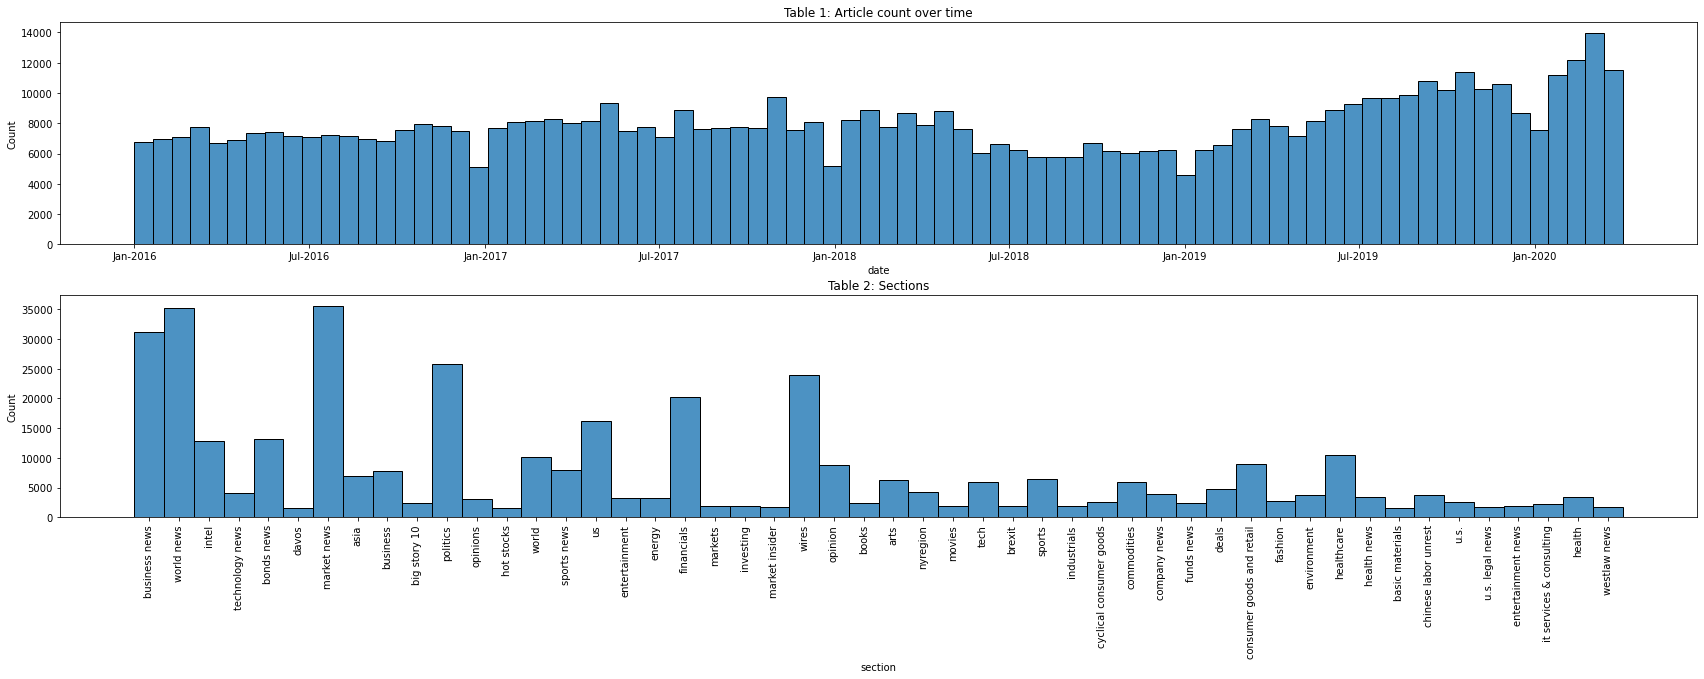

In [65]:
# Plot article time count and section relevance

fig, axes = plt.subplots(2, 1, figsize=(24, 8))              # Define the subplot space
fig.tight_layout(pad=3)                                      # Tighten layout to prevent overlap

sns.histplot(                                                # Seaborn histogram
    ax=axes[0],                                              # axes position to occupy
    data=main_df, x="date",                                  # data to use, define x
    alpha=.8, linewidth=1,                                   # Aesthetics
)

sns.histplot(                                                # Seaborn histogram
    ax=axes[1],                                              # axes position to occupy
    data=plt_df, x="section",                                # data to use, define x
    alpha=.8, linewidth=1,                                   # Aesthetics
)

# Pass title names, reformat x axis labels
monthyearFmt = mdates.DateFormatter('%b-%Y')
axes[0].xaxis.set_major_formatter(monthyearFmt)
_ = axes[0].set_title('Table 1: Article count over time')
axes[1].tick_params(axis='x', rotation=90)
_ = axes[1].set_title('Table 2: Sections')

## Build dictionary - Politics

Hassan and coauthors have two methods of building their political and non-political dictionaries, namely using textbooks or news articles. In this script we opt for the second one, and use the same keyword _domestic politics_ to draw a subset of articles from to build the political dictionary.

In [66]:
# Drop articles without any text
main_df = main_df.dropna(subset=['article'])

In [74]:
# Select rows given loc boolean with articles that include word politics
politics_df = main_df.loc[main_df.article.str.contains('politics')]

In [75]:
politics_df.shape

(25265, 6)

### Text Preprocessing

In [76]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer

In [77]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
stop_words = stopwords.words('english')
stop_words.append('hes')
stemmer = SnowballStemmer('english')

In [78]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    no_numbers = [w if not w.isdigit() else '' for w in nostop]          # normalize numbers
    stem_text  = [stemmer.stem(w) for w in no_numbers]                   # stem each word
    
    
    return stem_text

In [79]:
politics_df = politics_df.copy()                          # Create a copy of original file (hack to prevent pandas warnings)

politics_df['preproc'] = (                                # Create column in dataframe "politics_df" using multi-line
    politics_df['article']                                # Use data in article column to create preproc
    .astype(str)                                          # As type string, prevent floats/ints from exiting your code
    .progress_apply(lambda p: normalize_text(p))      # Apply the function normalize_text() to each row using apply (or tqdm's wrapper around apply called progress_apply)
)

politics_df['preproc'] = [' '.join(word) for word in politics_df['preproc']] # Join the lists of tokens

100%|████████████████████████████████████████████████████████████████████████████| 25265/25265 [04:40<00:00, 90.06it/s]


In [88]:
politics_df.article.iloc[0]

'WASHINGTON (Reuters) - China has delivered a written response to U.S. demands for wide-ranging trade reforms, three U.S. government sources said on Wednesday, a move that could trigger more formal negotiations to resolve a withering trade war between the world’s top economies.  U.S. President Donald Trump has imposed tariffs on $250 billion of Chinese imports to force concessions from Beijing on the list of demands that would change the terms of trade between the two countries. China has responded with import tariffs on U.S. goods.   Trump is expected to meet Chinese President Xi Jinping on the sidelines of a G20 summit in Argentina at the end of November and in early December.   The U.S. president has repeatedly railed against Beijing over intellectual property theft, industrial subsidies, Chinese entry barriers to American businesses and the U.S. trade deficit with China.  Three U.S. government sources told Reuters on Wednesday that China had sent a response to U.S. demands on those

In [89]:
politics_df.preproc.iloc[0]

'washington reuter china deliv written respons us demand widerang trade reform three us govern sourc said wednesday move could trigger formal negoti resolv wither trade war world top economi us presid donald trump impos tariff  billion chines import forc concess beij list demand would chang term trade two countri china respond import tariff us good trump expect meet chines presid xi jinp sidelin g20 summit argentina end novemb earli decemb us presid repeat rail beij intellectu properti theft industri subsidi chines entri barrier american busi us trade deficit china three us govern sourc told reuter wednesday china sent respons us demand issu gave detail content unclear respons contain concess would satisfi trump demand chang two industri sourc familiar content respons said larg restat previous chines commit seen necessari start point continu negoti two side far apart monthslong tariff disput one sourc brief china respons said reiter pledg xi made recent speech demand unit state lift ta

#### Political dictionary

In [90]:
from sklearn.feature_extraction.text import CountVectorizer

In [91]:
#Get the term-document matrix of bigrams
countvec = CountVectorizer(
    analyzer  = 'word',        # Arg: feature as word (use analyzer to collapse all steps in the future!)
    ngram_range = (2, 2),      # Arg: a range of n-grams to extract as features 
    stop_words = None,         # Arg: stopwords (already removed above)
    encoding = "utf-8",        # Arg: Variable-width encoding
    decode_error = "replace",  # Arg: Instruction to deal with non-UTF-8
    max_features = 1000,       # Arg: Maximum number of features
    min_df = 1e-3,             # Arg: Minimum frequency of words-features
    max_df = 0.6               # Arg: Maximum frequency of words-features
)

data_tf = countvec.fit_transform(politics_df.preproc)        # Train and transform  

X_mat = data_tf.todense()                                    # Output in dense format

words = countvec.get_feature_names()                         # Store word names

X_mat.shape

# Create dataframe with rows as documents and columns as features selected
x_df = pd.DataFrame(X_mat)
x_df.columns = words

In [92]:
x_df.shape

(25265, 1000)

In [93]:
x_df.head(10)

,2019 capitol,20th centuri,21st centuri,abort right,abus power,accord new,across countri,addit report,address win,administr offici,...,year mr,year old,year said,year sinc,yet anoth,york citi,york time,young peopl,your go,youv got
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Wordcloud

In [101]:
# Per word total frequency
word_counts = x_df.sum(axis=0).reset_index()

In [102]:
# Dictionary of term: frequency
word_counts = dict(zip(word_counts['index'], word_counts[0]))

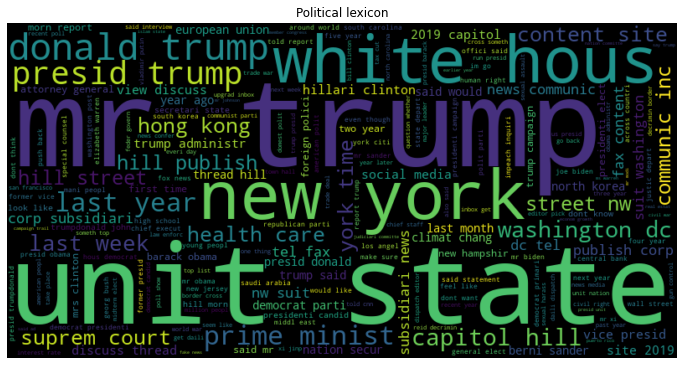

In [95]:
# Create wordcloud 
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(word_counts)

fig, _ = plt.subplots(1,1,figsize=(12,10))
plt.imshow(wc, interpolation = 'bilinear')
_.set_title('Political lexicon')
plt.axis("off")
plt.show()

### Risk synonyms

Hassan and coauthors use risk and a set of synonyms in order to build a measure of political risk that only takes into account political term occurrences when in proximity of a synonym of risk. We use the same synonyms below. 

In [104]:
risk_syn = (
    risk_syn
    ['risk']
    .str
    .lower()
    .apply(lambda x: stemmer.stem(x))
    .tolist()
)

## Risk in politics

Before building a dictionary of political terms not related to the economy ($\mathbb{P} \backslash \mathbb{N}$), it is instructive to first look at a measure of risk that uses all relevant bigrams found in the step above ($\mathbb{P}$). Calling this measure _risk in politics_, the formula reads:

$$
\text { RiskPol }_{i t}=\frac{\sum_{b}^{B_{i t}}\left(1[b \in \mathbb{P}] \times 1[|b-r|<10] \times \frac{f_{b, P}}{B_{p}}\right)}{B_{i t}}
$$

#### Single Case
Let's see how this is calculated for a single article.

In [107]:
test = politics_df.preproc.iloc[0]

In [108]:
test

'washington reuter china deliv written respons us demand widerang trade reform three us govern sourc said wednesday move could trigger formal negoti resolv wither trade war world top economi us presid donald trump impos tariff  billion chines import forc concess beij list demand would chang term trade two countri china respond import tariff us good trump expect meet chines presid xi jinp sidelin g20 summit argentina end novemb earli decemb us presid repeat rail beij intellectu properti theft industri subsidi chines entri barrier american busi us trade deficit china three us govern sourc told reuter wednesday china sent respons us demand issu gave detail content unclear respons contain concess would satisfi trump demand chang two industri sourc familiar content respons said larg restat previous chines commit seen necessari start point continu negoti two side far apart monthslong tariff disput one sourc brief china respons said reiter pledg xi made recent speech demand unit state lift ta

In [110]:
bigrams = [b for b in list(map(' '.join, zip(test.split(' ')[:-1], test.split(' ')[1:])))]

In [111]:
ind_poli = [i for i, value in enumerate(bigrams) if value in words]

print(ind_poli)

[12, 14, 15, 24, 29, 30, 31, 48, 60, 61, 71, 91, 94, 153, 171, 176, 191, 193, 194, 195, 207, 212, 215, 216, 217, 279, 328, 330, 340, 347, 355, 361, 367, 373, 375, 377, 385, 387, 414, 490, 498, 502]


In [113]:
ind_risk = [i for i, x in enumerate(bigrams) if any(xx in x for xx in risk_syn)]

print(ind_risk)

[105, 106, 280, 281, 479, 480, 499, 500]


In [114]:
import sys
from termcolor import colored, cprint

col_test = test.split(' ')
col_test = [colored(x, 'blue') if i in ind_poli else colored(x, 'blue') if i-1 in ind_poli else x for i, x in enumerate(col_test) ]
col_test = [colored(x, 'red') if i in ind_risk else x for i, x in enumerate(col_test)]
print(' '.join(col_test))

washington reuter china deliv written respons us demand widerang trade reform three us govern sourc said wednesday move could trigger formal negoti resolv wither trade war world top economi us presid donald trump impos tariff  billion chines import forc concess beij list demand would chang term trade two countri china respond import tariff us good trump expect meet chines presid xi jinp sidelin g20 summit argentina end novemb earli decemb us presid repeat rail beij intellectu properti theft industri subsidi chines entri barrier american busi us trade deficit china three us govern sourc told reuter wednesday china sent respons us demand issu gave detail content unclear respons contain concess would satisfi trump demand chang two industri sourc familiar content respons said larg restat previous chines commit seen necessari start point continu negoti two side far apart monthslong tariff disput one sourc brief china respons said reiter pledg xi made recent speech demand unit state lift tar

In [115]:
ind_both = []
for i in ind_poli:
    for j in ind_risk:
        if abs(i-j) < 10:
            ind_both.append(i)
            
ind_both = list(sorted(set(ind_both)))

print(ind_both)

[279, 490, 498, 502]


In [116]:
ind_both = [x for i, x in enumerate(bigrams) if i in ind_both]

print(ind_both)

['trump also', 'work hard', 'next year', 'addit report']


In [117]:
f_bP = [word_counts[x] for x in ind_both]

print(f_bP)

[834, 549, 2250, 1069]


In [118]:
B_P = sum(list(word_counts.values()))

print(B_P)

1022764


In [119]:
word_weights = {}
for item in word_counts:
    word_weights[item] = word_counts[item]*100 / B_P

In [120]:
i = 0
for w in sorted(word_weights, key=word_weights.get, reverse=True):
    i+=1
    print(w, word_weights[w])
    if i > 20:
        break

mr trump 1.853311223312514
unit state 1.654536139324419
new york 1.5653660081895726
white hous 1.4015941116425685
donald trump 1.1008404675956525
presid trump 0.9224024310593646
prime minist 0.817979514335663
last year 0.7559906293142895
capitol hill 0.6002362226280941
washington dc 0.5705128455831453
last week 0.533260850010364
york time 0.5092083804279384
hong kong 0.49864875963565397
health care 0.4817338115146798
suprem court 0.4753784841859901
content site 0.4743029672534426
hill publish 0.4741074187202522
street nw 0.4738140959204665
hill street 0.47361854738727605
communic inc 0.4735207731206808
corp subsidiari 0.4734229988540856


In [121]:
RiskPol_it = sum([word_weights[x] for x in ind_both])/len(bigrams)

print(RiskPol_it)

0.0008707094725961248


#### All cases

In [122]:
def abs_ind(ind_poli, ind_risk):
    ind_both = []
    for i in ind_poli:
        for j in ind_risk:
            if abs(i-j) < 10:
                ind_both.append(i)
    return list(sorted(set(ind_both)))

In [123]:
politics_df = (
    politics_df
    .assign(
        bigrams=lambda df: df.preproc.progress_apply(lambda row: [b for b in list(map(' '.join, zip(row.split(' ')[:-1], row.split(' ')[1:])))]),
        ind_poli=lambda df: df.bigrams.progress_apply(lambda row: [i for i, x in enumerate(row) if x in words]),
        ind_risk=lambda df: df.bigrams.progress_apply(lambda row: [i for i, x in enumerate(row) if any(xx in x for xx in risk_syn)]),
        idx_both=lambda df: df.progress_apply(lambda row: abs_ind(row.ind_poli, row.ind_risk), axis=1),
        ind_both=lambda df: df.progress_apply(lambda row: [x for i, x in enumerate(row.bigrams) if i in row.idx_both], axis=1),
        risk_pol=lambda df: df.progress_apply(lambda row: sum([word_weights[x] for x in row.ind_both])/len(row.bigrams), axis=1)
    )
)

100%|█████████████████████████████████████████████████████████████████████████| 25265/25265 [00:00<00:00, 37090.39it/s]


In [124]:
politics_df.head(4)

,date,author,title,article,section,publication,preproc,bigrams,ind_poli,ind_risk,idx_both,ind_both,risk_pol
0,2018-11-14,"Jeff Mason, David Shepardson",Exclusive: China sends written response to U.S. trade reform demands - U.S. government sources,"WASHINGTON (Reuters) - China has delivered a written response to U.S. demands for wide-ranging trade reforms, three U.S. government sources said on Wednesday, a move that could trigger more formal...",business news,Reuters,washington reuter china deliv written respons us demand widerang trade reform three us govern sourc said wednesday move could trigger formal negoti resolv wither trade war world top economi us pre...,"[washington reuter, reuter china, china deliv, deliv written, written respons, respons us, us demand, demand widerang, widerang trade, trade reform, reform three, three us, us govern, govern sourc...","[12, 14, 15, 24, 29, 30, 31, 48, 60, 61, 71, 91, 94, 153, 171, 176, 191, 193, 194, 195, 207, 212, 215, 216, 217, 279, 328, 330, 340, 347, 355, 361, 367, 373, 375, 377, 385, 387, 414, 490, 498, 502]","[105, 106, 280, 281, 479, 480, 499, 500]","[279, 490, 498, 502]","[trump also, work hard, next year, addit report]",0.000871
1,2019-06-20,"Andrew Osborn, Maria Kiselyova",Putin: ready for Trump talks but U.S. elections could complicate ties,"MOSCOW (Reuters) - Russian President Vladimir Putin said on Thursday he was ready to hold talks with Donald Trump if that was what his U.S. counterpart wanted, but added that Trump’s re-election c...",world news,Reuters,moscow reuter russian presid vladimir putin said thursday readi hold talk donald trump us counterpart want ad trump reelect campaign could complic usrussia relat trump said expect meet putin g20 s...,"[moscow reuter, reuter russian, russian presid, presid vladimir, vladimir putin, putin said, said thursday, thursday readi, readi hold, hold talk, talk donald, donald trump, trump us, us counterpa...","[2, 3, 4, 6, 11, 17, 24, 33, 56, 93, 122, 123, 136, 138, 139, 161, 176, 178, 185, 189, 190, 192, 197]","[116, 117]","[122, 123]","[said trump, trump drive]",0.000706
2,2016-03-07,"Mark Hosenball, Arshad Mohammed, Matt Spetalnick",Foreign diplomats voicing alarm to U.S. officials about Trump,WASHINGTON (Reuters) - Foreign diplomats are expressing alarm to U.S. government officials about what they say are inflammatory and insulting public statements by Republican presidential front-ru...,intel,Reuters,washington reuter foreign diplomat express alarm us govern offici say inflammatori insult public statement republican presidenti frontrunn donald trump accord senior us offici offici europ middl e...,"[washington reuter, reuter foreign, foreign diplomat, diplomat express, express alarm, alarm us, us govern, govern offici, offici say, say inflammatori, inflammatori insult, insult public, public ...","[6, 7, 8, 14, 17, 25, 27, 47, 60, 62, 80, 85, 91, 97, 103, 107, 128, 143, 145, 146, 164, 167, 170, 171, 175, 186, 187, 196, 199, 210, 228, 233, 240, 252, 267, 274, 280, 285, 286, 294, 302, 339, 35...","[136, 137, 151, 152, 461, 462, 593, 594]","[128, 143, 145, 146]","[critic trump, trump campaign, respond request, request comment]",0.000733
3,2018-01-04,NaN,Turkey warns those who would interfere in Iran politics,"ANKARA (Reuters) - Turkey on Thursday warned against external parties attempting to interfere in Iran’s domestic politics, saying that such actions could provoke a backlash, after six days of anti...",world news,Reuters,ankara reuter turkey thursday warn extern parti attempt interfer iran domest polit say action could provok backlash six day antigovern protest iran presid tayyip erdogan spokesman ibrahim kalin al...,"[ankara reuter, reuter turkey, turkey thursday, thursday warn, warn extern, extern parti, parti attempt, attempt interfer, interfer iran, iran domest, domest polit, polit say, say action, action c...","[10, 29, 31]","[38, 39]","[29, 31]","[told report, news confer]",0.004724


In [125]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
politics_df['risk_pol'] = scaler.fit_transform(politics_df[['risk_pol']].to_numpy())

In [129]:
politics_df.loc[politics_df.risk_pol.idxmax()].article

'NEW YORK (Reuters) - The United States is trying to promote a humanitarian crisis in Venezuela by imposing new sanctions, Foreign Affairs Minister Jorge Arreaza said on Friday after the sanctions were announced by the White House. Speaking at the U.N. headquarters in New York, Arreaza said “threats” and “supposed sanctions” from the United States are “uncivilized politics.” He said Venezuelan President Nicolas Maduro will not attend the annual gathering of world leaders at the U.N., scheduled for next month. Reporting by Rodrigo Campos and Riham Alkousaa; Editing by Bill Trott'

In [127]:
politics_df.loc[politics_df.risk_pol.idxmin()].article

'BRUSSELS (Reuters) - When the men who run the European Union pick its new leaders this year, they might finally appoint a few more women. But don’t expect a radical change any time soon.  The EU has opened talks to name the people who will run its key institutions for the next five years. The top post at the European Central Bank, picked every eight years, comes vacant this year too.  Negotiators in Brussels and European capitals will have to weigh the interests of north and south, right and left, big countries and small, richer and poorer. But this year, there is more pressure than usual to balance the sexes too.  None of the three most powerful European institutions - the EU’s executive Commission, its Council of national leaders and the ECB - has ever been led by a woman.  “This situation is ridiculous. There are still too few women. That applies to all the other top jobs in the EU,” the outgoing Commission president, Jean-Claude Juncker, who has just one woman among his six deputi

## Plot the index 

In [130]:
plt_df = (
    politics_df
    .assign(date=lambda df: pd.to_datetime(df.date))
    .resample('W', on='date')
    .risk_pol.mean()
    .reset_index()
    .assign(
        risk_pol=lambda df: df.risk_pol.fillna(0),
        date=lambda df: df.date.dt.date
    )
)

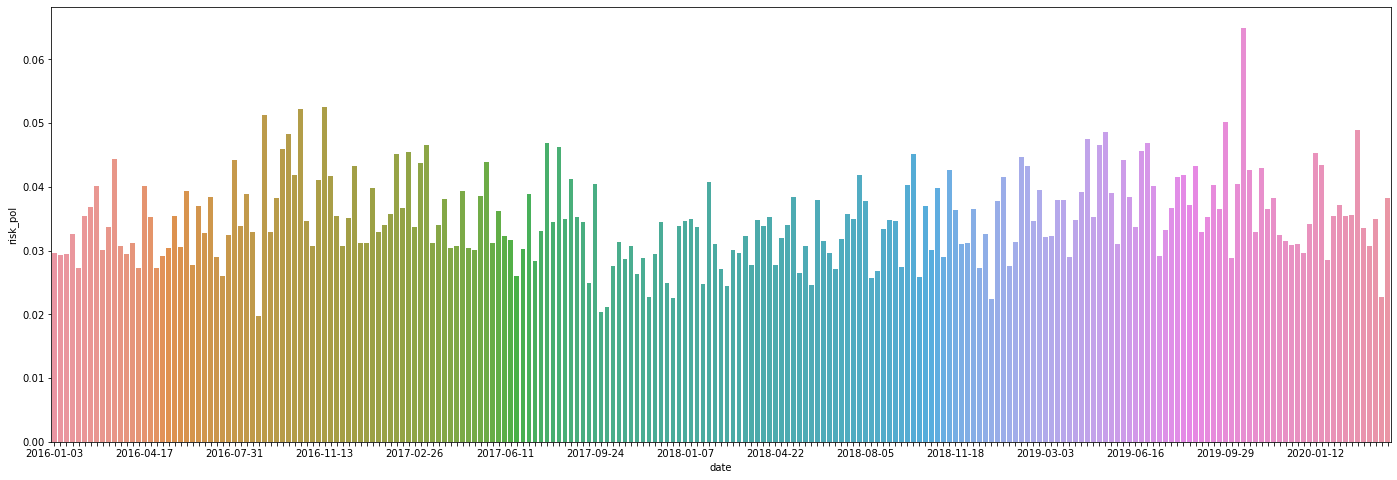

In [131]:
plt.figure(figsize=(24,8))
ax = sns.barplot(x='date', y='risk_pol', data=plt_df)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

In [132]:
politics_df.sort_values(by=['risk_pol'], ascending=False)[:5]

,date,author,title,article,section,publication,preproc,bigrams,ind_poli,ind_risk,idx_both,ind_both,risk_pol
340725,2017-08-25 00:00:00,NaN,U.S. trying to promote crisis in Venezuela: foreign minister,"NEW YORK (Reuters) - The United States is trying to promote a humanitarian crisis in Venezuela by imposing new sanctions, Foreign Affairs Minister Jorge Arreaza said on Friday after the sanctions ...",world news,Reuters,new york reuter unit state tri promot humanitarian crisi venezuela impos new sanction foreign affair minist jorg arreaza said friday sanction announc white hous speak un headquart new york arreaza...,"[new york, york reuter, reuter unit, unit state, state tri, tri promot, promot humanitarian, humanitarian crisi, crisi venezuela, venezuela impos, impos new, new sanction, sanction foreign, foreig...","[0, 3, 13, 18, 22, 27, 34, 37, 46, 50]","[30, 31]","[22, 27, 34, 37]","[white hous, new york, unit state, polit said]",1.000000
414824,2017-08-10 00:00:00,NaN,"U.S. will take ""appropriate measures"" on North Korea - Trump adviser","LONDON, Aug 10 (Reuters) - An adviser to U.S. President Donald Trump said on Thursday that Washington would use “any appropriate measures” to protect the United States from threats from North Kore...",industrials,Reuters,london aug reuter advis us presid donald trump said thursday washington would use appropri measur protect unit state threat north korea said develop plan fire rocket close us territori guam donal...,"[london aug, aug , reuter, reuter advis, advis us, us presid, presid donald, donald trump, trump said, said thursday, thursday washington, washington would, would use, use appropri, appropri meas...","[5, 6, 7, 8, 9, 17, 20, 31, 38, 45, 72, 79, 87, 92, 96]","[18, 19, 32, 33, 100, 101]","[9, 17, 20, 31, 38, 92, 96]","[said thursday, unit state, north korea, donald trump, unit state, nuclear weapon, unit state]",0.785080
91830,2018-12-31 05:00:07,Jeffery C. Mays,N.Y.’s New Attorney General Is Targeting Trump. Will Judges See a ‘Political Vendetta?’,"[What you need to know to start the day: Get New York Today in your inbox.] Letitia James, the incoming New York attorney general, has made no secret of how she feels about President Trump. She ca...",nyregion,The New York Times,need know start day get new york today inbox letitia jame incom new york attorney general made secret feel presid trump call illegitim presid say decis run attorney general larg man white hous can...,"[need know, know start, start day, day get, get new, new york, york today, today inbox, inbox letitia, letitia jame, jame incom, incom new, new york, york attorney, attorney general, general made,...","[0, 5, 12, 14, 19, 20, 27, 31, 41, 42, 45, 52, 55, 64, 66, 72, 78, 103, 105, 111, 112, 118, 132, 135, 144, 146, 159, 177, 178, 181, 185, 201, 204, 222, 236, 237, 249, 291, 299, 340, 341, 350, 363,...","[13, 14, 26, 27, 36, 37, 63, 64, 96, 97, 134, 135, 200, 201, 223, 224, 240, 241, 248, 249, 300, 301, 403, 404, 412, 413, 423, 424, 572, 573, 620, 621, 648, 649, 673, 674, 688, 689]","[5, 12, 14, 19, 20, 27, 31, 41, 42, 45, 55, 64, 66, 72, 103, 105, 132, 135, 144, 201, 204, 222, 236, 237, 249, 291, 299, 404, 410, 413, 424, 426, 428, 429, 571, 573, 580, 581, 582, 621, 644, 657, ...","[new york, new york, attorney general, presid trump, trump call, attorney general, white hous, mr trump, trump could, obstruct justic, real estat, attorney general, across countri, new york, mr tr...",0.590450
349679,2017-07-28 18:27:53,Alan Blinder,"Alabama May Be Trump Country, but It’s Standing With Sessions","PAINT ROCK, Ala. — At a senior center here in the northeast corner of Alabama, one decree ordinarily rises above the rules of Rook and dominoes: No talking about politics or religion. But by late ...",us,The New York Times,paint rock ala — senior center northeast corner alabama one decre ordinarili rise rule rook domino talk polit religion late week day watch presid trump excori belittl attorney general jeff session...,"[paint roc

In [133]:
politics_df['risk_level'] = pd.qcut(politics_df['risk_pol'], 10, labels=False, duplicates='drop')

In [134]:
ctab = pd.crosstab(politics_df.publication, politics_df.risk_level)
ctab

risk_level,0,1,2,3,4,5,6,7,8
publication,,,,,,,,,
Axios,271,44,37,41,52,33,45,33,64
Business Insider,112,74,44,39,38,49,41,49,36
CNBC,352,222,256,249,259,245,216,230,204
CNN,617,296,365,392,395,372,346,392,279
Economist,250,180,171,135,144,139,101,90,110
Mashable,249,86,74,47,40,33,30,27,18
Reuters,827,330,352,337,326,282,305,285,232
TechCrunch,100,47,22,25,20,11,13,5,2
The Hill,820,381,395,506,515,540,606,611,479


In [135]:
plt_df = pd.melt(ctab, var_name='qtile', ignore_index=False).reset_index()

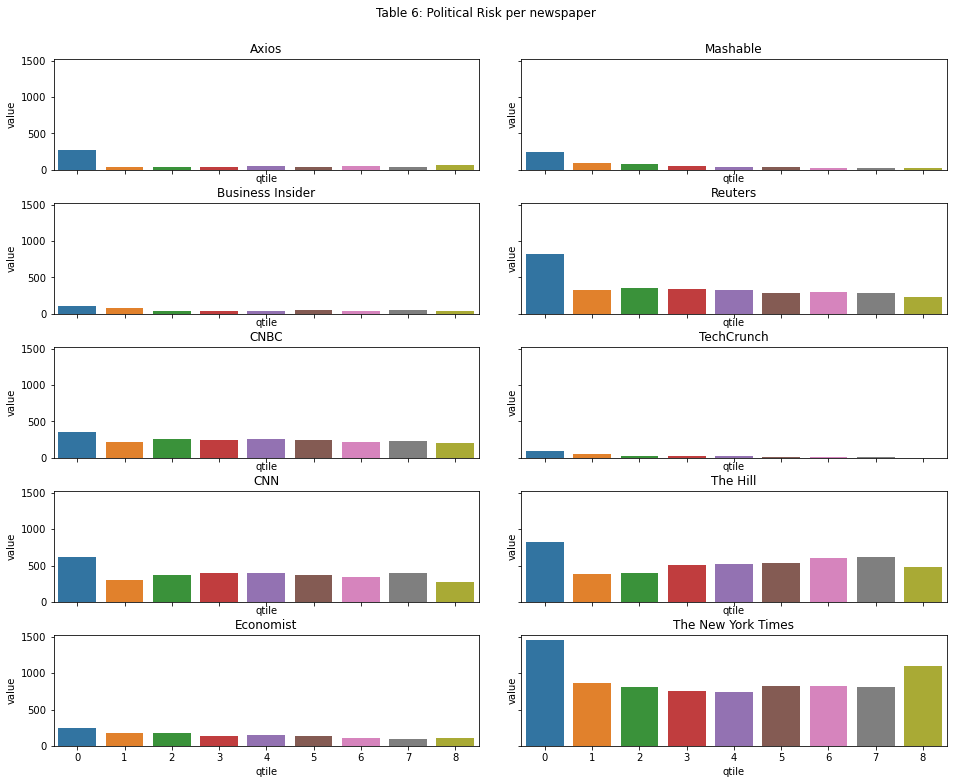

In [136]:
#Plot evolution in tweet sentiment
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,12), sharex=True, sharey=True,gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

fig.suptitle('Table 6: Political Risk per newspaper')
fig.subplots_adjust(top=0.92)

for i, col in enumerate(plt_df.publication.unique()):
    q, mod = divmod(i,5)
    tmp_df = plt_df.loc[plt_df.publication==col]
    sns.barplot(ax=ax[mod,q], x='qtile',y='value',data=tmp_df)
    ax[mod,q].set_title(col)

## Build dictionary - Non-Politics, i.e. economics

In [137]:
economics_df = main_df.loc[main_df.article.str.contains('performance')]

In [138]:
economics_df = economics_df.copy()

economics_df['preproc'] = (
    economics_df['article']
    .astype(str)
    .progress_apply(lambda row: normalize_text(row))
)

economics_df['preproc'] = [' '.join(word) for word in economics_df['preproc']]

100%|███████████████████████████████████████████████████████████████████████████| 30670/30670 [04:26<00:00, 115.02it/s]


In [139]:
#Get the term-document matrix of bigrams
countvec_ec = CountVectorizer(
    analyzer  = 'word',         # Arg: feature as word
    ngram_range  = (2, 2),      # Arg: a range of n-grams to extract as features 
    stop_words   = None,        # Arg: stopwords (already removed above)
    encoding     = "utf-8",     # Arg: Variable-width encoding
    decode_error = "replace",   # Arg: Instruction to deal with non-UTF-8
    max_features = 1000,        # Arg: Maximum number of features
    min_df       = 1e-3,        # Arg: Minimum frequency of words-features
    max_df       = 0.6          # Arg: Maximum frequency of words-features
)

data_tf_ec = countvec_ec.fit_transform(economics_df.preproc)    # Train and transform  

X_mat_ec = data_tf_ec.todense()                                 # Output in dense format

words_ec = countvec_ec.get_feature_names()                         # Store word names

X_mat_ec.shape

# Data snippet
x_df_ec = pd.DataFrame(X_mat_ec)
x_df_ec.columns = words_ec

In [140]:
word_counts_ec = x_df_ec.sum(axis=0).reset_index()
word_counts_ec = dict(zip(word_counts_ec['index'], word_counts_ec[0]))

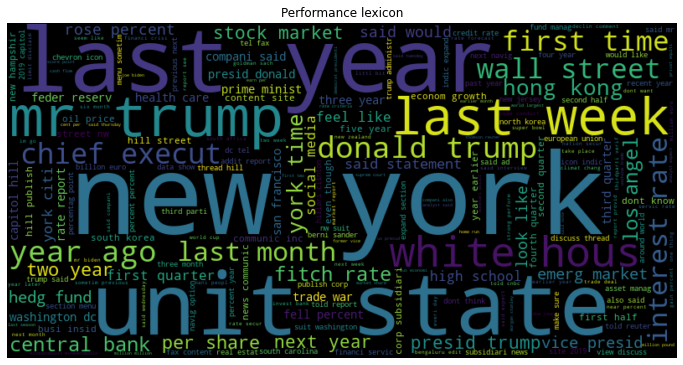

In [141]:
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(word_counts_ec)

fig, _ = plt.subplots(1,1,figsize=(12,10))
_.set_title('Performance lexicon')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Hassan et al.'s Political risk measure

The paper's methodology takes measuring political risk one step further. Since words typically associated to political events may also be widely used in non-political topics, simply using their frequency in political newspaper articles may yield noisy measures of risk. In order to tackle this issue, Hassan and coauthors present a slight variation of the formula above, which reads:

$$
\text { PRisk }_{i t}=\frac{\sum_{b}^{B_{i t}}\left(1[b \in \mathbb{P} \backslash \mathbb{N}] \times 1[|b-r|<10] \times \frac{f_{b, P}}{B_{p}}\right)}{B_{i t}}
$$

The main difference is that the indicator function now only activates for words in the political lexicon **not** present in the non-political one. The authors claim that in this way they are able to capture discussions on political events that are unrelated to other topics, thus increasing precision and reducing noise in the measurement variable. Let us replicate their methodology on the sample of articles that mention India and China, and see how the U.S. perception of risk towards either country changes over time. 

In [142]:
words_polrisk = [x for x in words if x not in words_ec]

In [143]:
f_word_counts = {k: word_counts[k] for k in words_polrisk if k in word_counts}

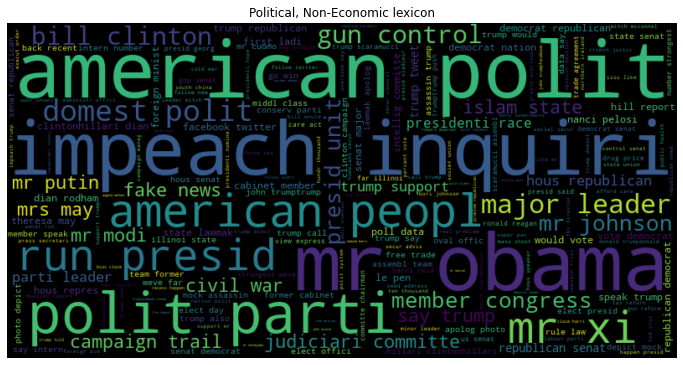

In [144]:
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(f_word_counts)

fig, _ = plt.subplots(1,1,figsize=(12,10))
plt.imshow(wc, interpolation = 'bilinear')
_.set_title('Political, Non-Economic lexicon')
plt.axis("off")
plt.show()

In [145]:
len(words_polrisk)

591

## Conference calls

In [146]:
earnconfcall_lst = os.listdir(datadir / 'ConferenceCalls' / 'Dataset')

In [147]:
transcripts = []
for item in earnconfcall_lst:
    with open(datadir / 'ConferenceCalls' / 'Dataset' / item / 'text.txt', encoding="utf8") as infile:
        tmp_ = infile.read()
        date_ = item[:8]
        comp_ = item[9:]
        transcripts.append([comp_, date_, tmp_])
        
transcripts_df = pd.DataFrame(transcripts, columns =['company', 'date', 'text'])

In [148]:
transcripts_df['date'] = pd.to_datetime(transcripts_df['date'])
transcripts_df['text'] = transcripts_df['text'].str.normalize("NFKD")
transcripts_df['text'] = transcripts_df['text'].str.replace('\n', ' ')
transcripts_df['word_len'] = transcripts_df['text'].str.split().str.len()

# Keep transcripts with some text
transcripts_df = transcripts_df.loc[transcripts_df['word_len']>5]

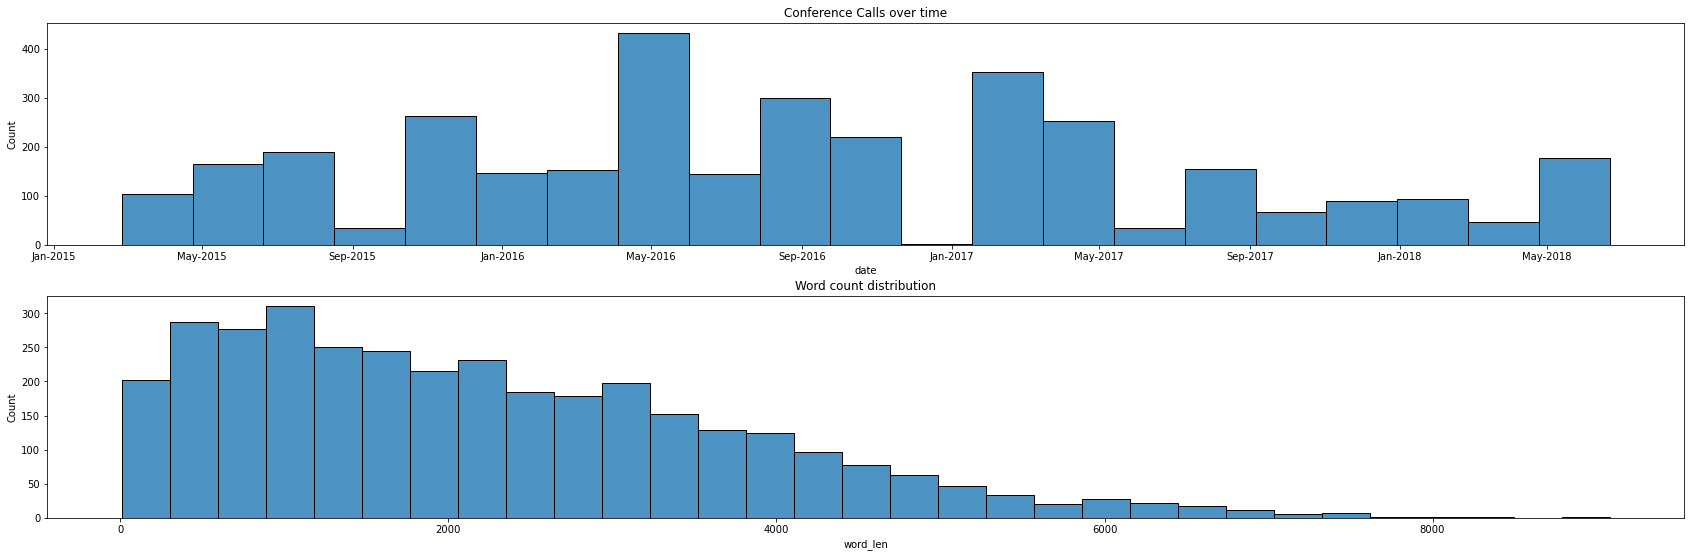

In [149]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
fig.tight_layout(pad=3)

sns.histplot(
    ax=axes[0],
    data=transcripts_df, x="date",
    alpha=.8, linewidth=1,
)

sns.histplot(
    ax=axes[1],
    data=transcripts_df, x="word_len",
    alpha=.8, linewidth=1,
)

axes[0].xaxis.set_major_formatter(monthyearFmt)
_ = axes[0].set_title('Conference Calls over time')
_ = axes[1].set_title('Word count distribution')

In [150]:
transcripts_df['preproc_lst'] = (
    transcripts_df['text']
    .astype(str)
    .progress_apply(lambda row: normalize_text(row))
)

transcripts_df['preproc'] = [' '.join(word) for word in transcripts_df['preproc_lst']]

100%|██████████████████████████████████████████████████████████████████████████████| 3419/3419 [01:07<00:00, 50.68it/s]


In [151]:
from collections import Counter

full_transcripts=np.hstack(transcripts_df['preproc_lst'])
full_transcripts = Counter(full_transcripts)

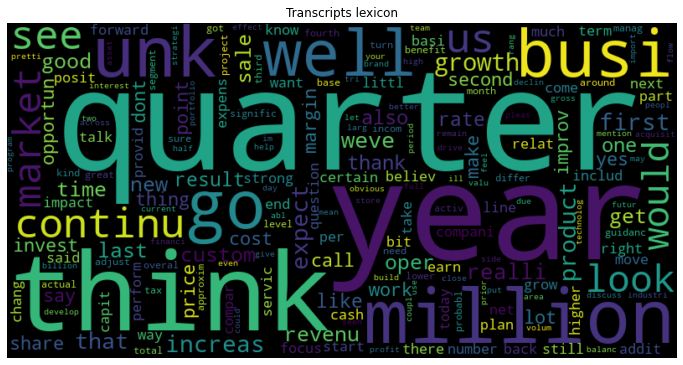

In [152]:
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(full_transcripts)

fig, _ = plt.subplots(1,1,figsize=(12,10))
plt.imshow(wc, interpolation = 'bilinear')
_.set_title('Transcripts lexicon')
plt.axis("off")
plt.show()

### Political Risk measure on transcripts

In [153]:
transcripts_df = (
    transcripts_df
    .assign(
        bigrams=lambda df: df.preproc.progress_apply(lambda row: [b for b in list(map(' '.join, zip(row.split(' ')[:-1], row.split(' ')[1:])))]),
        ind_poli=lambda df: df.bigrams.progress_apply(lambda row: [i for i, x in enumerate(row) if x in words_polrisk]),
        ind_risk=lambda df: df.bigrams.progress_apply(lambda row: [i for i, x in enumerate(row) if any(xx in x for xx in risk_syn)]),
        idx_both=lambda df: df.progress_apply(lambda row: abs_ind(row.ind_poli, row.ind_risk), axis=1),
        ind_both=lambda df: df.progress_apply(lambda row: [x for i, x in enumerate(row.bigrams) if i in row.idx_both], axis=1),
        pol_risk=lambda df: df.progress_apply(lambda row: sum([word_weights[x] for x in row.ind_both])/len(row.bigrams), axis=1)
    )
)

100%|███████████████████████████████████████████████████████████████████████████| 3419/3419 [00:00<00:00, 41695.72it/s]


In [154]:
def col_pol(text, indicator_pol, indicator_risk):
    '''
    Color text according to risk/PN words
    '''
    cold_pol = text.split(' ')
    cold_pol = [
        colored(x, 'blue') if i in indicator_pol 
        else colored(x, 'blue') if i-1 in indicator_pol
        else x 
        for i, x in enumerate(cold_pol)
    ]
    
    cold_pol = [
        colored(x, 'red') if i in indicator_risk
        else x 
        for i, x in enumerate(cold_pol)
    ]
    
    return ' '.join(cold_pol)

In [155]:
risk_max = transcripts_df.loc[transcripts_df.idx_both.str.len().idxmax()]
print(col_pol(risk_max.preproc, risk_max.ind_poli, risk_max.ind_risk))

thank glenda good afternoon everyon name bob unk vice presid investor relat emerg thank join us today discuss oper financi result first quarter  customari today call open particip addit call record copyright emerg biosolut particip call prepar comment dan unk chief execut offic bob unk presid chief oper offic rich unk new appoint chief financi offic member senior team present avail qa session follow prepar comment begin remind everyon today call either prepar comment qa session manag may make project forwardlook statement relat busi futur event prospect futur perform forwardlook statement base current intent belief expect regard futur event cannot guarante forwardlook statement accur investor realiz under assumpt prove inaccur unknown risk uncertainti materi actual result could differ materi expect investor therefor caution place undu relianc forwardlook statement forwardlook statement speak date press releas except requir law undertak updat forwardlook statement reflect new inform eve

In [156]:
risk_min = transcripts_df.loc[transcripts_df.pol_risk.idxmin()]
print(col_pol(risk_min.preproc, risk_min.ind_poli, risk_min.ind_risk))

im way shape form im bad didnt sign dont feel bad least bit answer let unk answer big part question emv enabl way realli didnt much emv busi last year spent money get everyon readi saa enabl whatnot thought peopl come run tri go protect quick possibl didnt see much lot retail side side surpris us littl bit think peopl buy  solut check box start loss think get sell  solut unk answer expect sign big deal year would also say sale guidanc necessarili conting upon deliv larg deal close one larg deal unk talk like go push us snet guidanc rang provid updat time good morn part strong sale  begin get benefit sale  project exampl sold  host begin come onlin  well realli look back   organ snet growth   organ snet growth that start come onlin  yet look recal  actual go back hiccup convers s1 bill  actual signific declin cash flow catchup cash flow  normal balanc yes optic catchup year  term model free cash flow consist model past look ebitda ebitda rang  million  million cash tax would deduct  mil

In [76]:
print(transcripts_df.sort_values(by=['pol_risk'], ascending=False)[:5]['text'].values)

['<UNK>, we are not saying there is no risk but we feel good about the things that we can do here to have a better back half. Okay. '
 "It is retired. No, we discussed the area of the concern, which is Houston. We can't really see any other place where we are. I think we're pretty well-diversified by industry type and markets, so we feel because of that diversification we have a level of safety. No, in fact automotive has been very strong and suburban Detroit has been doing extremely well. So there are areas in and around Detroit where we think that automotive can be a good play. (multiple speakers). No, it is a few miles from their headquarters. Thank you. Yes, we came in at like $27.1 million in 2015, to TIs and leasing costs, and we project it in 2016 to be about $25 million. Time will tell how things are looking when we get to that point later in the year. Right now we continue to view the buyback as the better use of capital. Great, thanks to all of you again for joining us this m

#### Plot

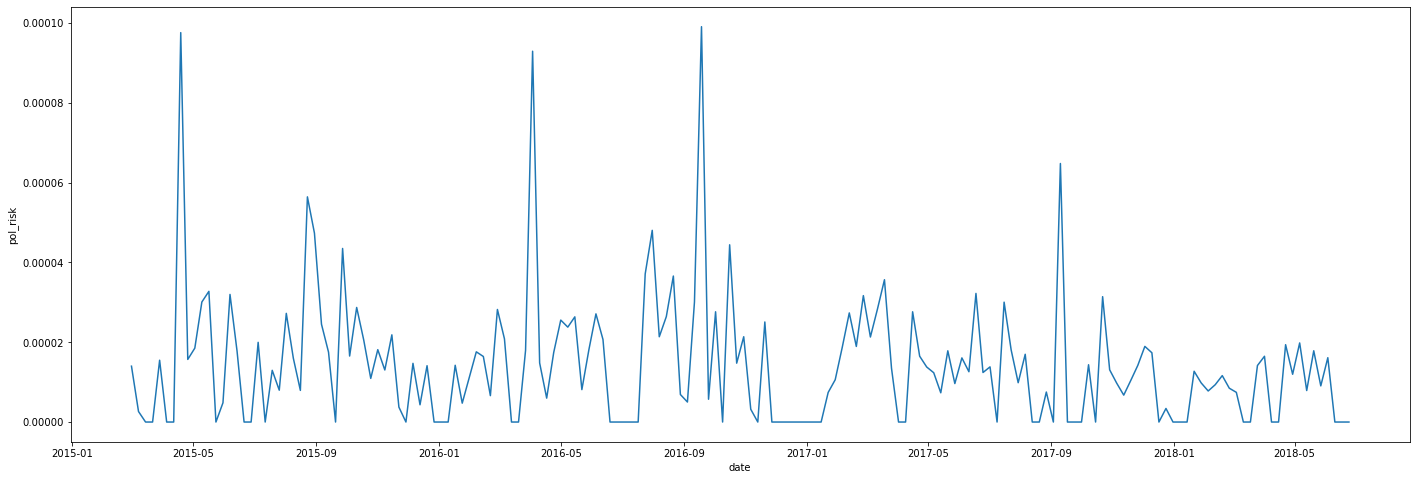

In [157]:
plt_df = (
    transcripts_df
    .resample('W', on='date')
    .pol_risk.mean()
    .reset_index()
    .assign(
        pol_risk=lambda df: df.pol_risk.fillna(0),
        date=lambda df: df.date.dt.date
    )
)

plt.figure(figsize=(24,8))
ax = sns.lineplot(x='date', y='pol_risk', data=plt_df)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 1 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

In [158]:
(
    transcripts_df
    .loc[transcripts_df['date']<'2015-07-01']
    .loc[lambda df: df.idx_both.str.len().argsort()[-1:]]
    .apply(lambda row: print(col_pol(row.preproc, row.ind_poli, row.ind_risk)), axis=1)
)

well see tremend potenti growth apj lot world import compani major world popul lot endus come onlin lot potenti growth us build strength experi manag team that would see announc talk go forward unk yes mean think weve talk media busi variabl quarter quarter game releas softwar updat thing natur think weve said consist expect busi grow midteen kind ongo basi go quarter year grow well north quarter year grow littl bit less believ go strong midteen grower kind longterm would say period go faster period go lower yes mean math kind perform secur categori nonsecur busi grew  consist grew q4 pretti solid growth imagin secur new offer compani new offer think prolex acquisit there lot train would say focus sale forc sell secur one thing share addit weve build sale forc sale forc also sell media think see sale forc sell myriad solut think see littl bit stronger growth media certain secur think web perform growth rate pretti good think certain web perform growth rate think impact mayb focus secur

110    None
dtype: object

## Sentiment Analysis

In [173]:
emotions_df = emotions_df.set_index('English (en)').T

In [174]:
emotions_df

English (en),aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
Positive,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
Negative,0,0,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Anger,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Anticipation,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Disgust,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fear,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Joy,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Sadness,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Surprise,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Trust,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [175]:
sentiment_dict = {}
for i, row in emotions_df.iterrows():
    x = [str(x).lower() for x in list(row.index) if row[x] == 1]
    sentiment_dict[str(i).lower()] = x

In [176]:
sentiment_dict.keys()

dict_keys(['positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'])

In [177]:
def sentiment_eval(_list, text):
    result = [x for x in text if x in _list]
    return len(result)

In [178]:
transcripts_df = (
    transcripts_df.copy()
    .assign(
        text=lambda df: df.text.str.translate(remove_punct),
        split_article=lambda df: df.text.str.split(),
        positive=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['positive'])),
        negative=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['negative'])),
        anger=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['anger'])),
        anticipation=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['anticipation'])),
        disgust=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['disgust'])),
        fear=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['fear'])),
        joy=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['joy'])),
        sadness=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['sadness'])),
        surprise=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['surprise'])),
        trust=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['trust'])),
    )
)

100%|████████████████████████████████████████████████████████████████████████████| 3419/3419 [00:00<00:00, 6812.90it/s]


In [166]:
cols = list(sentiment_dict.keys())

for col in cols:
    transcripts_df[col] = transcripts_df.copy()[col].str.len()

In [167]:
plt_df = (
    transcripts_df
    .assign(date=lambda df: pd.to_datetime(df.date))
    .set_index('date')
    .resample('W')
    .agg(
        {
            'positive': 'mean',
            'negative': 'mean',
            'anger': 'mean',
            'anticipation': 'mean',
            'disgust': 'mean',
            'fear': 'mean',
            'joy': 'mean',
            'sadness': 'mean',
            'surprise': 'mean',
            'trust': 'mean',
        }
    )
    .reset_index()
    .assign(
        date=lambda df: df.date.dt.date,
        positive=lambda df: df.positive.fillna(df.positive.mean()),
        negative=lambda df: df.negative.fillna(df.negative.mean()),
        anger=lambda df: df.anger.fillna(df.anger.mean()),
        anticipation=lambda df: df.anticipation.fillna(df.anticipation.mean()),
        disgust=lambda df: df.disgust.fillna(df.disgust.mean()),
        fear=lambda df: df.fear.fillna(df.fear.mean()),
        joy=lambda df: df.joy.fillna(df.joy.mean()),
        sadness=lambda df: df.sadness.fillna(df.sadness.mean()),
        surprise=lambda df: df.surprise.fillna(df.surprise.mean()),
        trust=lambda df: df.trust.fillna(df.trust.mean())
    )
)

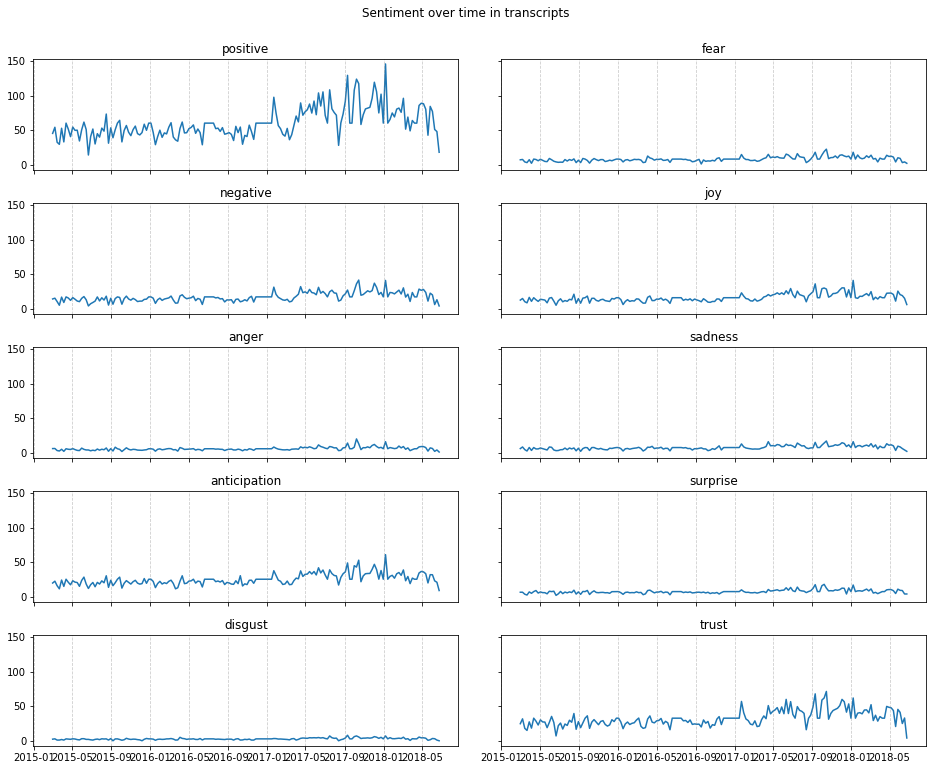

In [168]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,12), sharex=True, sharey=True,gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

fig.suptitle(f'Sentiment over time in transcripts')
fig.subplots_adjust(top=0.92)

for i, col in enumerate(cols):
    q, mod = divmod(i,5)
    ax[mod,q].plot(plt_df['date'],plt_df[col],zorder=0)
    ax[mod,q].set_title(col)
    ax[mod,q].xaxis.grid(color='gray', linestyle='dashed',alpha=0.4)

### Beyond: Sentiment interacted with the political, non-political dictionary

Hassan and coauthors interact the sentiment measure (in this case, only positive and negative terms) with the political, non-political matches in the conference calls corpus. Their new political sentiment measure looks as follows.

$$
\text { PSentiment }_{i, t}=\frac{1}{B_{i t}} \sum_{b}^{B_{i t}}\left(1[b \in \mathbb{P} \backslash \mathbb{N}] \times \frac{f_{b, \mathbb{P}}}{B_{\mathrm{P}}} \times \sum_{c=b-10}^{b+10} S(c)\right)
$$

Given the tools above, you should be able to now recreate this measure. Happy coding!

### Alternative application: China, India datasets

As an alternative application of dictionary methods, think of an analyst at a private bank who's in charge of monitoring sentiment and political events in China and India. We can then use newspaper articles and extract similar measures of political risk as the ones above in order to track the evolution of such risk over time in either country.

In [182]:
china_df = (
    main_df
    .dropna(subset=['title'])
    .loc[lambda df: df.title.str.contains('China')]
)
print(f'China df shape: {china_df.shape}')

india_df = (
    main_df
    .dropna(subset=['title'])
    .loc[lambda df: df.title.str.contains('India')]
)

print(f'India df shape: {india_df.shape}')

China df shape: (57211, 6)
India df shape: (20224, 6)


#### Plot publication shares for China, India

In [183]:
general_shares = (
    main_df
    .groupby('publication').agg({'title': 'count'})
    .apply(lambda x: x / x.sum(), axis=0)
    .sort_values(by='title', ascending=False)
    .rename(columns={'title': 'general'})
)

china_shares = (
    china_df
    .groupby('publication').agg({'title': 'count'})
    .apply(lambda x: x / x.sum(), axis=0)
    .sort_values(by='title', ascending=False)
    .rename(columns={'title': 'china'})
)

india_shares = (
    india_df
    .groupby('publication').agg({'title': 'count'})
    .apply(lambda x: x / x.sum(), axis=0)
    .sort_values(by='title', ascending=False)
    .rename(columns={'title': 'india'})
)

In [184]:
from functools import reduce

dfs = [general_shares, china_shares, india_shares]
shares_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)

In [185]:
plt_df = pd.melt(shares_df, var_name='dataset', ignore_index=False).reset_index()

In [186]:
shares_df

,general,china,india
publication,,,
Reuters,0.432745,0.575886,0.656201
CNBC,0.129852,0.222754,0.085591
The New York Times,0.124831,0.059272,0.070510
The Hill,0.105183,0.037266,0.024624
CNN,0.065405,0.035762,0.052710
Mashable,0.047869,0.007254,0.042326
Business Insider,0.029738,0.014211,0.007961
TechCrunch,0.027114,0.012096,0.031695
Axios,0.024625,0.020783,0.008604


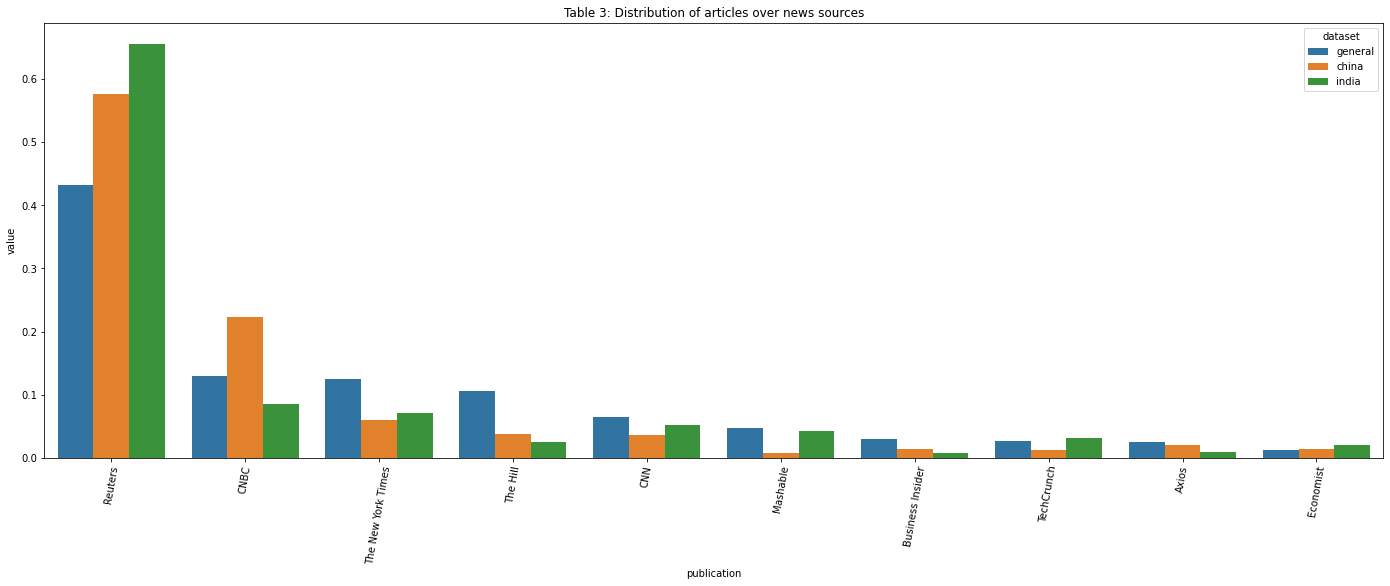

In [187]:
plt.figure(figsize=(24,8))
ax = sns.barplot(x='publication', y='value', hue='dataset', data=plt_df)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
_ = ax.set_title('Table 3: Distribution of articles over news sources')

In [188]:
china_df = (
    china_df.loc[china_df.article.str.len() > 2000]
    .drop_duplicates(subset = ['author', 'title'])
    .dropna(subset=['article'])
)

india_df = (
    india_df.loc[india_df.article.str.len() > 2000]
    .drop_duplicates(subset = ['author', 'title'])
    .dropna(subset=['article'])
)

chi_ind_df = pd.concat([china_df.sample(5000, random_state = 42), india_df.sample(5000, random_state = 42)])

chi_ind_df['preproc'] = (
    chi_ind_df['article']
    .astype(str)
    .progress_apply(lambda row: normalize_text(row))
)

chi_ind_df['preproc'] = [' '.join(word) for word in chi_ind_df['preproc']]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 130.68it/s]


In [189]:
chind_risk_df = (
    chi_ind_df
    .assign(
        bigrams=lambda df: df.preproc.progress_apply(lambda row: [b for b in list(map(' '.join, zip(row.split(' ')[:-1], row.split(' ')[1:])))]),
        ind_poli=lambda df: df.bigrams.progress_apply(lambda row: [i for i, x in enumerate(row) if x in words]),
        ind_risk=lambda df: df.bigrams.progress_apply(lambda row: [i for i, x in enumerate(row) if any(xx in x for xx in risk_syn)]),
        idx_both=lambda df: df.progress_apply(lambda row: abs_ind(row.ind_poli, row.ind_risk), axis=1),
        ind_both=lambda df: df.progress_apply(lambda row: [x for i, x in enumerate(row.bigrams) if i in row.idx_both], axis=1),
        pol_risk=lambda df: df.progress_apply(lambda row: sum([word_weights[x] for x in row.ind_both])/len(row.bigrams), axis=1)
    )
)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3788.51it/s]


In [97]:
chind_risk_df = chind_risk_df.loc[chind_risk_df.ind_risk.str.len()>0]

### Highest, lowest

In [98]:
def col_pol(text, indicator_pol, indicator_risk):
    
    cold_pol = text.split(' ')
    cold_pol = [
        colored(x, 'blue') if i in indicator_pol 
        else colored(x, 'blue') if i-1 in indicator_pol
        else x 
        for i, x in enumerate(cold_pol)
    ]
    
    cold_pol = [
        colored(x, 'red') if i in indicator_risk
        else x 
        for i, x in enumerate(cold_pol)
    ]
    
    return ' '.join(cold_pol)

In [99]:
risk_max = chind_risk_df.loc[chind_risk_df.pol_risk.idxmax()]
print(col_pol(risk_max.preproc, risk_max.ind_poli, risk_max.ind_risk))

beij march  reuter chines state media tuesday defend countri  percent budget increas militari spend year proportion low say beij goad arm race unit state china monday unveil largest defenc spend increas three year fuell ambiti militari modernis programm make neighbour particular japan selfrul taiwan nervous defenc spend figur close watch worldwid clue china strateg intent develop new militari capabl includ stealth fighter aircraft carrier antisatellit missil china insist militari spend transpar pose threat nobodi simpli need updat old equip defend legitim interest even increas assert disput east south china sea selfrul taiwan china claim editori offici china daili said figur prompt fingerpoint usual suspect china defenc budget neither largest size account onefourth militari spend unit state fastest growth rate englishlanguag newspap said calcul per capita term china militari lag well behind major countri east south china sea china simpli tri stand paper ad countri seen maritim interest

In [100]:
risk_min = chind_risk_df.loc[chind_risk_df.pol_risk.idxmin()]
print(col_pol(risk_min.preproc, risk_min.ind_poli, risk_min.ind_risk))

add comment updat price palladium hit record high 226145oz platinum surpass  first time near  year harshith aranya jan  reuter gold rose wednesday detail uschina phase  trade deal fail sooth investor concern trade differ washington retain tariff chines good precious metal palladium climb record high platinum surg highest near two year unit state china sign interim trade deal roll back tariff boost chines purchas us good servic deal howev leav place  tariff  billion array chines industri good compon use us manufactur spot gold rose   per ounc  pm est  gmt us gold futur settl   expect trade concern go continu linger go see complet rollback tariff said edward moya senior market analyst oanda risk keep gold price support short term might see price target  next week right  hold focus shift phase  deal like focus technolog cybersecur issu us treasuri secretari steven mnuchin said long sore point two giant economi key world stock market index climb new record us dollar weaken basket key rival

## Plot results

In [101]:
chind_risk_df['country'] = np.where(chind_risk_df.title.str.contains('China'), 'China', 'India')

scaler = MinMaxScaler()
chind_risk_df['pol_risk'] = scaler.fit_transform(chind_risk_df[['pol_risk']].to_numpy())

In [102]:
plt_df = (
    chind_risk_df
    .assign(date=lambda df: pd.to_datetime(df.date))
    .set_index('date')
    .groupby('country')
    .resample('M')
    .pol_risk.mean()
    .reset_index()
    .assign(
        pol_risk=lambda df: df.pol_risk.fillna(0),
        date=lambda df: df.date.dt.date
    )
)

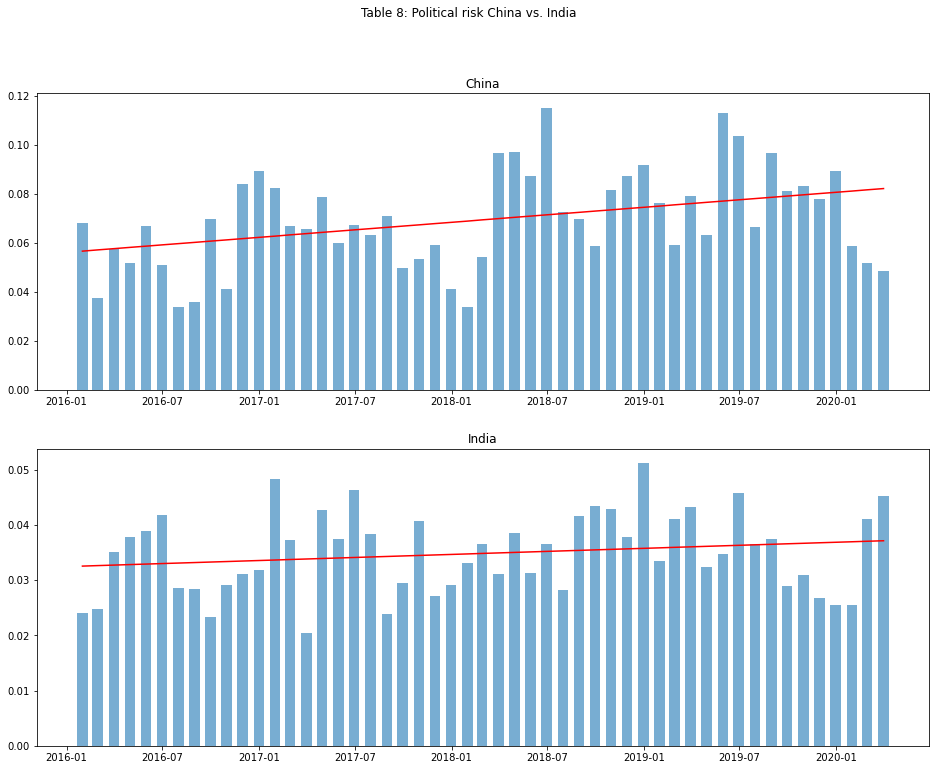

In [103]:
#Plot evolution in tweet sentiment
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,12), sharex=False)

fig.suptitle('Table 8: Political risk China vs. India')

for i, col in enumerate(plt_df.country.unique()):
    q, mod = divmod(i,1)
    tmp_df = plt_df.loc[plt_df.country==col]
#     sns.barplot(ax=ax[q], x='date', y='pol_risk',data=tmp_df)
    ax[q].bar(x='date', height='pol_risk', data=tmp_df, width=20, alpha=.6)
    
    #Plot line fit
    x = np.arange(len(tmp_df))
    fit = np.polyfit(x, tmp_df['pol_risk'], 1)
    fit_fn = np.poly1d(fit)
    ax[q].plot(tmp_df['date'], fit_fn(x), color='red')
    ax[q].set_title(col)

#### China top results

In [104]:
for i in chind_risk_df.loc[chind_risk_df.country=='China'].sort_values(by=['pol_risk'], ascending=False)[:10].index:
    print(chind_risk_df.loc[i]['title'])

China defends defence spending rise as low, proportional
Trump Expected to List China Tariffs, Potentially Reigniting Trade War
Trump and Xi Jinping, China’s Leader, Hold Cordial First Phone Call
China says no one should bring chaos to Korean peninsula
Taiwan says China pressure not delaying plan for president's trip
Dems split in debate on China, nukes, climate change as biggest threats to US
Mnuchin: Trump not afraid of a trade war with China - Fox News
Dollar inches higher as markets cautious on U.S.-China meeting
Opinion | China Can Thrive in the Trump Era
Stocks Rise on Wall Street Even as Trade Fight Between U.S. and China Grows


In [105]:
for i in chind_risk_df.loc[chind_risk_df.country=='China'].sort_values(by=['pol_risk'], ascending=True)[:10].index:
    print(chind_risk_df.loc[i]['title'])

2018 is the year India, China and Israel go to the moon | TheHill
US lawmakers say Trump has taken 'no meaningful action' over China's treatment of Muslims
China's Jingye Group agrees outline deal to rescue British Steel
China, oil and central banks create CEO gloom on economy
W.H.O. Warns of Worrisome Bird Flu in China
Beefed up: McDonald's edging out KFC, Pizza Hut in China revival battle
China urges cooperation after U.S. brands it a competitor
Mexico's governors tap investors in China, elsewhere
COLUMN-China crude oil imports may not suffer as much as consumption: Russell
Dogged by Brexit, Britain stumbles in race to woo China


#### India top results

In [106]:
for i in chind_risk_df.loc[chind_risk_df.country=='India'].sort_values(by=['pol_risk'], ascending=False)[:10].index:
    print(chind_risk_df.loc[i]['title'])

India's Wipro tops profit forecast on demand from key clients
India seeks waiver from U.S. steel and aluminum tariffs
India's Wipro sees muted revenue growth amid growing protectionism
India to pivot spending to the US, amid Russia arms deals sanctions
India's Wipro announces up to $1.7 billion share buyback as second-quarter forecast disappoints
Indian stocks crash into bear territory as virus now a pandemic
Indian stocks crash into bear territory as virus now a pandemic
India's Tata Consultancy beats third-quarter profit estimates
As Tillerson heads to Pakistan, Islamabad wary of deepening U.S.-India ties
Kasich campaign: Indiana results won't alter our plans | TheHill


In [107]:
for i in chind_risk_df.loc[chind_risk_df.country=='India'].sort_values(by=['pol_risk'], ascending=True)[:10].index:
    print(chind_risk_df.loc[i]['title'])

Snapdeal Raises $200M More To Fuel Up For India’s Ongoing E-Commerce Battle – TechCrunch
REFILE-Asia Gold-Slight retreat in prices adds to festive lure in India
India files trade complaint against U.S. over temporary work visas
Modi defends bank note move as Indians line up for cash
ASIA GOLD-Price rally, cash crunch dulls India's Akshaya Tritiya festival buying
Reliance Jio lured millions of Indians online with cheap data and is reshaping the internet
Why it is so hard to fix India’s sanitation - The Economist explains
Indian entrepreneur sells 'untouchable' foods to challenge caste bias
Indian wrestler Phogat ready for tilt at MMA world title
British PM Theresa May in India for state visit; trade, defense ties in focus


### Sentiment

In [108]:
chind_risk_df = (
    chind_risk_df.copy()
    .assign(
        text=lambda df: df.article.str.translate(remove_punct),
        split_article=lambda df: df.text.str.split(),
        positive=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['positive'])),
        negative=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['negative'])),
        anger=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['anger'])),
        anticipation=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['anticipation'])),
        disgust=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['disgust'])),
        fear=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['fear'])),
        joy=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['joy'])),
        sadness=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['sadness'])),
        surprise=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['surprise'])),
        trust=lambda df: df.split_article.progress_apply(lambda row: set(row) & set(sentiment_dict['trust'])),
    )
)

100%|███████████████████████████████████████████████████████████████████████████| 8793/8793 [00:00<00:00, 12543.58it/s]


In [109]:
cols = list(sentiment_dict.keys())

In [110]:
sentiment_df = chind_risk_df.copy()

In [111]:
for col in cols:
    sentiment_df[col] = sentiment_df[col].str.len()

In [112]:
plt_df = (
    sentiment_df
    .assign(date=lambda df: pd.to_datetime(df.date))
    .set_index('date')
    .groupby('country')
    .resample('W')
    .agg(
        {
            'positive': 'mean',
            'negative': 'mean',
            'anger': 'mean',
            'anticipation': 'mean',
            'disgust': 'mean',
            'fear': 'mean',
            'joy': 'mean',
            'sadness': 'mean',
            'surprise': 'mean',
            'trust': 'mean',
        }
    )
    .reset_index()
    .assign(
        date=lambda df: df.date.dt.date
    )
)

In [113]:
def plot_sentiment(cols, country):
    # Plot evolution in article sentiment
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,12), sharex=True, sharey=True,gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

    fig.suptitle(f'Sentiment mentions over time, {country}')
    fig.subplots_adjust(top=0.92)

    tmp_df = plt_df.loc[plt_df.country==country]
    for i, col in enumerate(cols):
        q, mod = divmod(i,5)
        ax[mod,q].plot(tmp_df['date'], tmp_df[col],zorder=0)
        ax[mod,q].set_title(col)
        ax[mod,q].xaxis.grid(color='gray', linestyle='dashed',alpha=0.4)
        
        #Plot line fit
        x = np.arange(tmp_df.shape[0])
        fit = np.polyfit(x, tmp_df[col], 2)
        fit_fn = np.poly1d(fit)
        ax[mod, q].plot(tmp_df['date'], fit_fn(x), color='red', alpha=0.2)

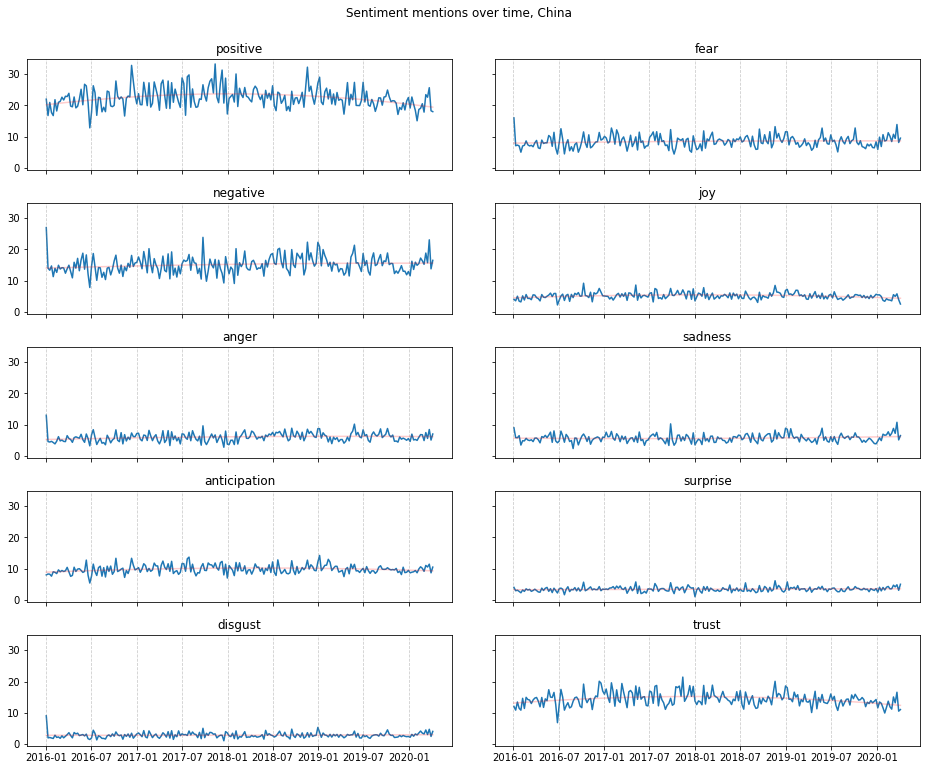

In [114]:
plot_sentiment(cols, 'China')

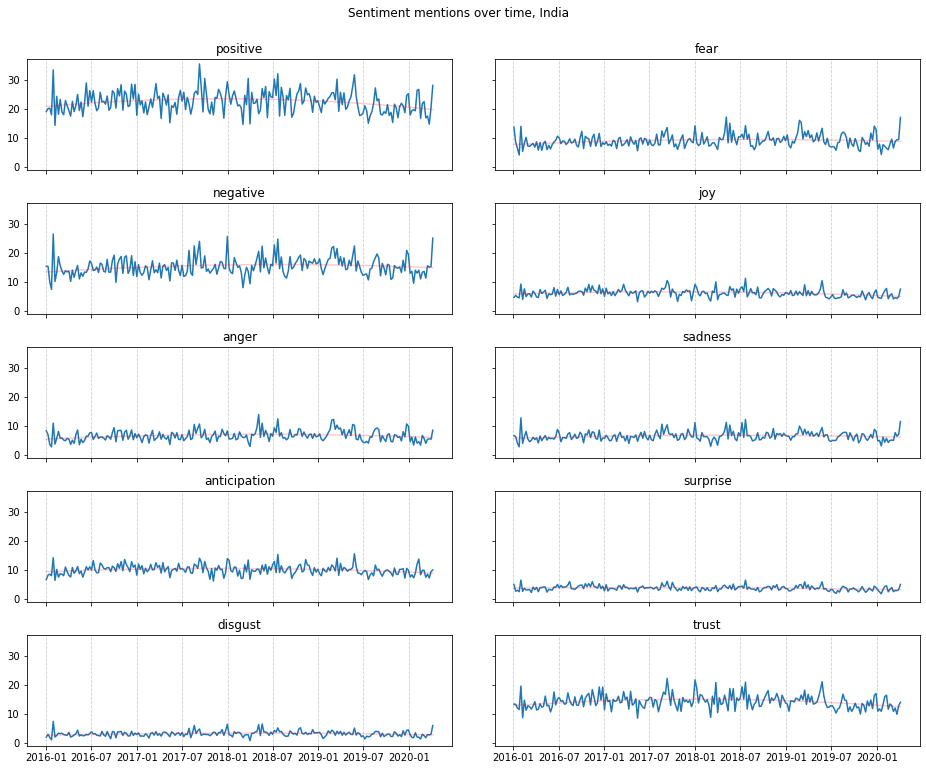

In [115]:
plot_sentiment(cols, 'India')

In [116]:
nwp = ['CNBC', 'CNN', 'Economist', 'The New York Times']

In [117]:
plt_df = (
    sentiment_df
    .assign(date=lambda df: pd.to_datetime(df.date))
    .set_index('date')
    .groupby(['country', 'publication'])
    .resample('M')
    .agg(
        {
            'positive': 'mean',
            'negative': 'mean',
            'anger': 'mean',
            'anticipation': 'mean',
            'disgust': 'mean',
            'fear': 'mean',
            'joy': 'mean',
            'sadness': 'mean',
            'surprise': 'mean',
            'trust': 'mean',
            'article': lambda x: x.str.len().mean()
        }
    )
    .reset_index()
    .assign(
        date=lambda df: df.date.dt.date,
        positive=lambda df: df.positive.fillna(df.positive.mean()),
        negative=lambda df: df.negative.fillna(df.negative.mean()),
        anger=lambda df: df.anger.fillna(df.anger.mean()),
        anticipation=lambda df: df.anticipation.fillna(df.anticipation.mean()),
        disgust=lambda df: df.disgust.fillna(df.disgust.mean()),
        fear=lambda df: df.fear.fillna(df.fear.mean()),
        joy=lambda df: df.joy.fillna(df.joy.mean()),
        sadness=lambda df: df.sadness.fillna(df.sadness.mean()),
        surprise=lambda df: df.surprise.fillna(df.surprise.mean()),
        trust=lambda df: df.trust.fillna(df.trust.mean()),
        article=lambda df: df.article.fillna(df.article.mean())
    )
    .loc[lambda df: df.publication.isin(nwp)]
)

In [118]:
for col in cols:
    plt_df[col] = plt_df[col]/plt_df['article']

In [119]:
def plot_one_sentiment(sentiment):
    # Plot evolution in article sentiment
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16,12), sharex=True, sharey=True,gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

    fig.suptitle(f'Table 10: {sentiment} mentions over time')
    fig.subplots_adjust(top=0.92)

    for i, publi in enumerate(nwp*2):
        if i < 4:
            country='China'
        else:
            country='India'
        q, mod = divmod(i,4)
        ax[mod,q].plot(plt_df.loc[(plt_df.country==country) & (plt_df.publication==publi)]['date'],plt_df.loc[(plt_df.country==country) & (plt_df.publication==publi)][sentiment],zorder=0)
        ax[mod,q].set_title(publi + '-' + country)
        ax[mod,q].xaxis.grid(color='gray', linestyle='dashed',alpha=0.4)
        ax[mod,q].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
        
        #Plot line fit
        x = np.arange(plt_df.loc[(plt_df.country==country) & (plt_df.publication==publi)].shape[0])
        fit = np.polyfit(x, plt_df.loc[(plt_df.country==country) & (plt_df.publication==publi)][sentiment], 1)
        fit_fn = np.poly1d(fit)
        ax[mod, q].plot(plt_df.loc[(plt_df.country==country) & (plt_df.publication==publi)]['date'], fit_fn(x), color='red', alpha=0.2)

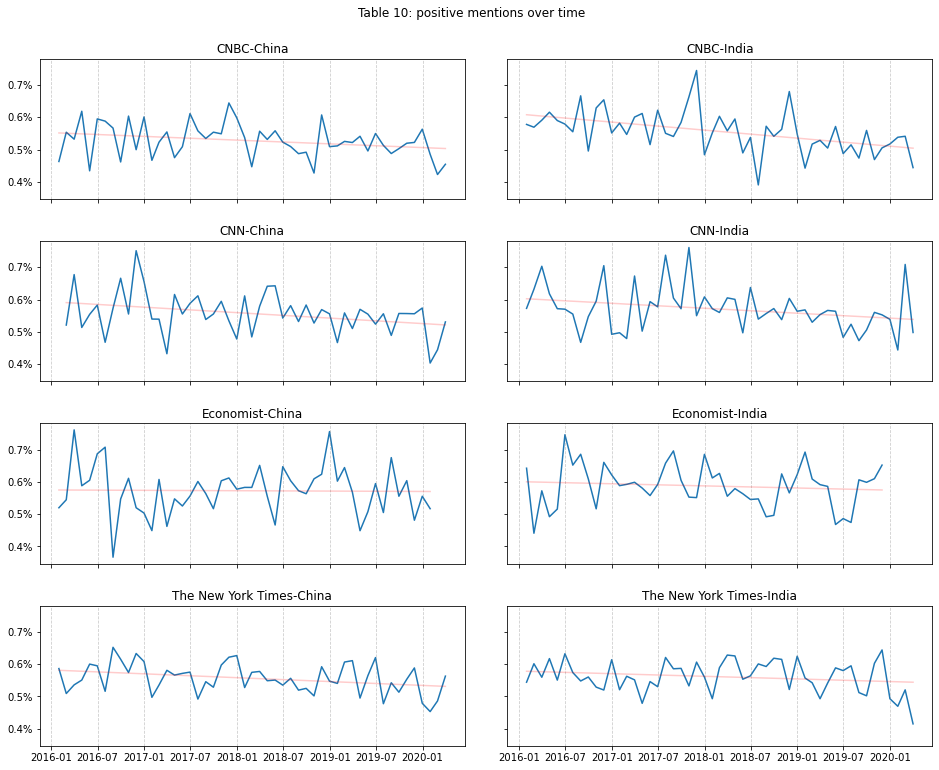

In [120]:
plot_one_sentiment('positive')

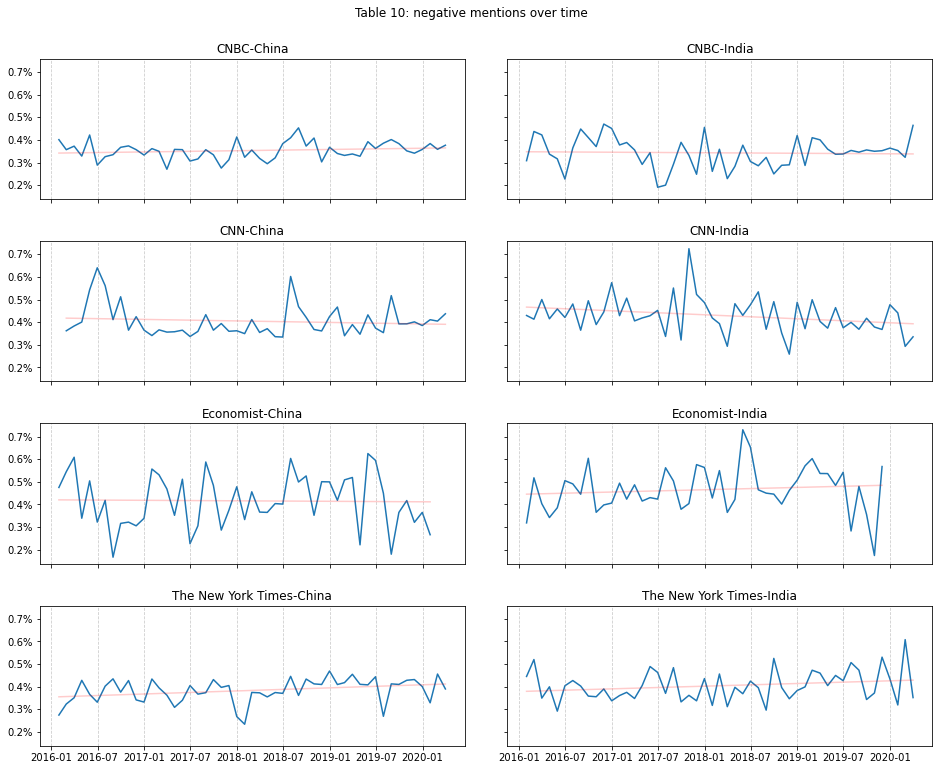

In [121]:
plot_one_sentiment('negative')